# Vehicle Detection

## Part 1: Bounding Boxes

The first step is to be able to identify the vehicles. This is done with bounding boxes.

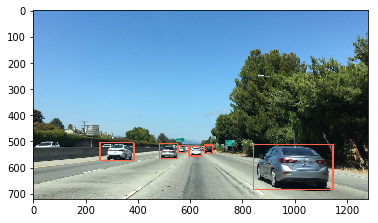

In [1]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from moviepy.editor import VideoFileClip
%matplotlib inline

#In part one of feature extraction we will draw bounding boxes:
image = mpimg.imread('bbox-eg.jpg')

def draw_boxes(img, bound_box, color = (255,99,71), thick = 4 ):
    loc_veh = np.copy(img)
    for e in bound_box:
        cv2.rectangle(loc_veh, e[0], e[1], color, thick)
    return loc_veh # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
#bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
bboxes = [((255,505), (385, 572)), ((484,508), (552, 565)), ((555,516), (583, 542)),\
 ((595,519), (643, 556)),((655,514), (685, 547)), ((842,512), (1146, 684))]

plt.imshow(draw_boxes(image, bboxes))

### Histograms of color

##### First, let me make sure that I understand numpy histograms: 
A histogram is NOT a bar chart, 

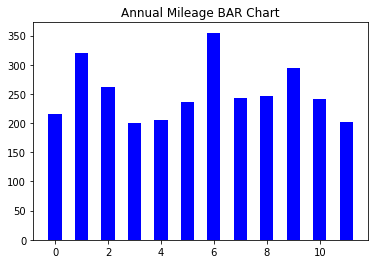

In [2]:
#Build a BAR CHART for a years worth of monthly mileage driven: 
mileage = np.random.uniform(180,400, size=12)
bins = []
for i in range(12):
    bins.append(i)

fig, ax = plt.subplots()
rects1 = ax.bar(bins, mileage, width=0.5, color='b')

plt.title("Annual Mileage BAR Chart")
plt.show()
#fig = plt.figure(figsize=(12,3))
#plt.subplot(141)
#plt.bar(bin_centers, rhist[0])

### HISTOGRAMS 
Now that I am no longer mistaking hitograms with bar charts...
A histogram is a colletion of rectangles whose areas are proportional to the frequency of a variable, whose width is equal to the class interval. 
- Bin repr width of each block along x-axis

In [3]:
#Building a histogram with the distances run: 


hist features [400 441 302 244 189 283 412 433 239 177 209 302 276 179 129 106 104 111
 106  96 111 123 139 130 167 164 149 156 222 268 258  53  95 219 441 331
 235 179 188 324 340 321 252 215 242 296 244 198 133 117  98 127  88 120
 104  88 117 172 152 142 133 159 219 589 106 206 367 337 230 174 235 328
 316 238 189 227 261 271 291 244 179 148 134 112 129 123  94  93 160 138
 117 110 121 148 219 633]


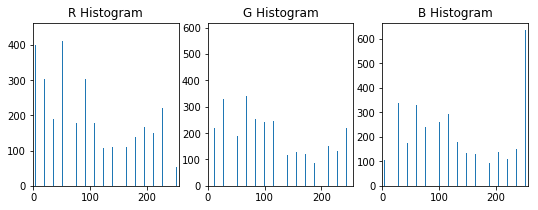

In [4]:
# Read in the image
image = mpimg.imread('cutout1.jpg')

def color_hist(img, nbins = 32, bins_range=(0,256)):
    # Take histograms in R, G, and B
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((rhist[0],ghist[0], bhist[0]))
    return rhist, ghist, bhist, bin_centers, hist_features
    

rhist, ghist, bhist, bin_centers, hist_features = color_hist(image)

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(141)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(142)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(143)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')
'''plt.subplot(144)
plt.bar(bin_centers, hist_features)
plt.xlim(0, 256)
plt.title('All 3 combined')
'''
print("hist features", hist_features)

### Eploring color spaces
What we want to do is transform various pictures into different color spaces, and see if there is a representation in which the pixels from car images stand out from non car images. 

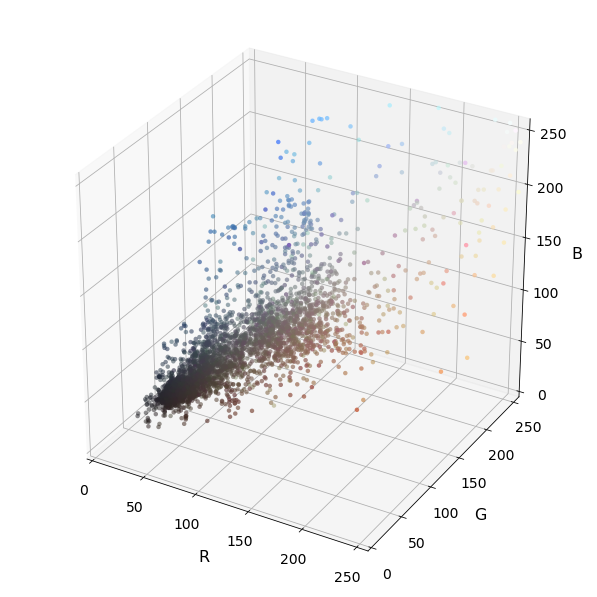

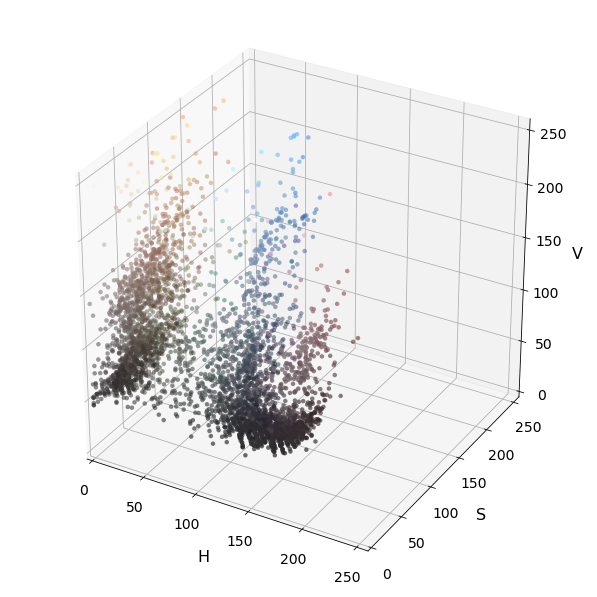

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
#img = cv2.imread("000275.png")
img = cv2.imread("colspaces/noncar2.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

### Resizing an image

image shape:  (130, 130, 3)
(32, 32, 3)


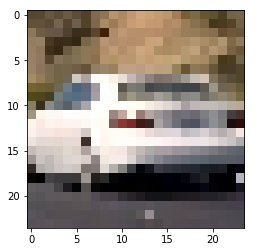

In [4]:
import cv2
import matplotlib.image as mpimg

image = mpimg.imread('test_img.jpg')
print("image shape: ",image.shape)
small_img = cv2.resize(image, (32, 32))
small_imga = cv2.resize(image, (8, 8))
small_imgb = cv2.resize(image, (24, 24))
print(small_img.shape)
#(32, 32, 3)
#plt.figure()
#plt.show(image)
plt.imshow(small_imgb)
#plt.imshow(small_imga)

In [5]:
feature_vec = small_img.ravel()
print(feature_vec.shape)
#(3072,)

(3072,)


### Color Feature Vectors
We are going to convert images into feature vectors, in the YUV color space

In [8]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='YUV') #leaving the size the same, as for the hogdescriptor below
print(feature_vec.shape)
print('no of axes(dimensions), or the length of the shape ', len(feature_vec.shape),"or: ", feature_vec.ndim)

(3072,)
no of axes(dimensions), or the length of the shape  1 or:  1


### Hog Descriptor
A faster alternative to hog made use of in the notes, is OpenCV's HOGDescriptor

In [10]:
image = cv2.imread('test_img.jpg')
hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)
h1 = hog.compute(image)
print(h1.shape)
print('no of axes(dimensions), or the length of the shape ', len(h1.shape),"or: ", h1.ndim)

(142884, 1)
no of axes(dimensions), or the length of the shape  2 or:  2


#### Feature vector
Now make a function that can take any test image and convert it into a feature vector to be fed into a classifier: 

## Part 2: Feature extraction

#### Pattern Matching
Although a combination of features (shape and color) would allow for the best results in many situations, in this exercise it is not the best method for realiably identifying cars. This is because the shape of the vehicle changes as the distance and orientation in relation to the dashboard camera changes. Pattern matching is **not** robust to these changes in dimension, shape and orientation. 

#### Histogram of color
The histogram of color (in RGB color space) does not identify vehicles in a color independent manner. It can identify vehicles in this space, but can get very complicated very quickly.  
 
#### Histogram of Gradients
Instead, a histogram of gradients (HOG) is used, to obtain a 'signature' for each individual image. This is robust to both color, and varying size and orientation. The HOG is carried out under a particular color space, and flattened, using np.ravel(). 
The flattened images are used to build the datasets with the label of either 'car' or 'not car'. 

##### My approach: Combining Spatial Binning and HOG in YUV
I will take the feature vectors and combine them.
* First, I read in the image with cv2
* Then make the two feature extraction methods
* Then I make the actual feat extraction method that calls the individual feat extract methods
* Then I run the car and non car datasets on this 
* Then I normalize and scale the data



'\nfor i in range(0, 10):\n    print("len of cars: %s"%i, len(cars), "featExt1: ", color_hist_feat_ext_1(cars[i]).shape,"feat_ext2: ",size_hog_feat_ext_2(cars[i]).shape)\n    print("len of cars: %s"%i, len(notcars), "featExt1: ", color_hist_feat_ext_1(notcars[i]).shape,"feat_ext2: ",size_hog_feat_ext_2(notcars[i]).shape)\n    print()\n#def extract_feats(cars, notcars):\n '

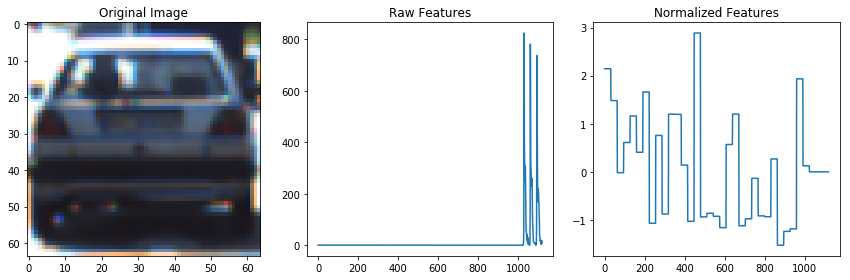

In [15]:
def color_hist(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def size_hog(image, size=(32, 32)):
    #img = cv2.imread(image)
    # Convert image to new color space (if specified)
    #feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)  
    #Use the faster cv2 hog function
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)
    #Extract the hog features
    hog_features = hog.compute(image)
    #Then resize and flatten:
    hog_features = cv2.resize(hog_features, size).ravel() 
    # Return the feature vector
    return hog_features
    


def extract_features(imgs):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)     
        # Apply bin_spatial() to get spatial color features
        spatial_features = size_hog(feature_image)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

cars = glob.glob('carpics/cars/*.png')
notcars = glob.glob('carpics/noncars/*.png')
        
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')


'''
for i in range(0, 10):
    print("len of cars: %s"%i, len(cars), "featExt1: ", color_hist_feat_ext_1(cars[i]).shape,"feat_ext2: ",size_hog_feat_ext_2(cars[i]).shape)
    print("len of cars: %s"%i, len(notcars), "featExt1: ", color_hist_feat_ext_1(notcars[i]).shape,"feat_ext2: ",size_hog_feat_ext_2(notcars[i]).shape)
    print()
#def extract_feats(cars, notcars):
 '''   

#### Get the car and non car datasets into the right folders and double check everything

Your function returned a count of 8667  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


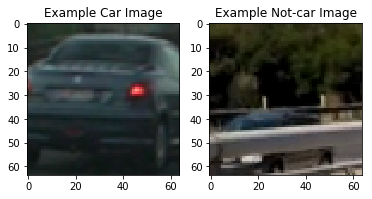

In [77]:
#car_features = extract_features(car_images)
#notcar_features = extract_features(car_images)

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(car_images, noncar_images)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Train Test Split
Now that we have features extracted, noramlized, scaled, etc. 
It is time to train a classifier


In [19]:
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

30.89 Seconds to train SVC...
Test Accuracy of SVC =  0.8509
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]
0.02702 Seconds to predict 10 labels with SVC
